In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [28]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]



In [29]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [30]:
tavily.invoke('Provide me the recent AI news for july 3rd 2025')

[{'title': 'Latest AI Breakthroughs and News: June-July 2025 - Crescendo.ai',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': '### HII and C3.ai Form Strategic AI Partnership for U.S. Navy\n\nDate: July 3, 2025  \nSummary: Defense contractor HII and enterprise AI firm C3.ai have announced a strategic partnership to support U.S. Navy shipbuilding. The collaboration will apply AI to design optimization, logistics, and predictive maintenance. It aligns with the Pentagonâ\x80\x99s goal of accelerating AI adoption across military operations. Both companies will co-develop tools tailored for naval missions.  \nSource: HII News [...] Date: July 6, 2025  \nSummary: Amazon and Walmart are racing to integrate AI across logistics, pricing, and customer personalization to gain a retail edge. Amazon is investing in generative AI for supply chain automation, while Walmart is enhancing its predictive analytics and voice shopping. The competition is reshaping global r

In [31]:
tools=[arxiv,wiki,tavily,add,divide,multiply]

In [32]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = 'llama-3.3-70b-versatile')
llm_with_tools = llm.bind_tools(tools)

In [33]:
llm.invoke("What is the recent AI news")

AIMessage(content="There have been several recent developments in the field of Artificial Intelligence (AI). Here are some of the most notable ones:\n\n1. **ChatGPT and Large Language Models**: OpenAI's ChatGPT has been making waves in the AI community with its ability to generate human-like text and converse with users. Other companies like Google and Microsoft are also working on similar large language models.\n2. **Google's Bard AI**: Google has recently launched its own AI chatbot called Bard, which is designed to provide more accurate and informative responses than traditional chatbots.\n3. **Microsoft's AI-powered Bing**: Microsoft has integrated AI into its Bing search engine, allowing users to ask questions and receive more detailed and personalized answers.\n4. **AI-generated Art and Music**: AI algorithms have been used to generate art, music, and even entire albums. This has raised questions about the role of human creativity in the age of AI.\n5. **AI-powered Robotics**: Co

In [34]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5a8qt7h7n', 'function': {'arguments': '{"query":"Recent AI News"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 744, 'total_tokens': 764, 'completion_time': 0.072727273, 'prompt_time': 0.257679169, 'queue_time': 0.053008318, 'total_time': 0.330406442}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d1317ba7-0bf2-474f-a491-1eeefdad6b80-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Recent AI News'}, 'id': '5a8qt7h7n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 744, 'output_tokens': 20, 'total_tokens': 764})

In [35]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '30bqp2wd9',
  'type': 'tool_call'}]

In [36]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

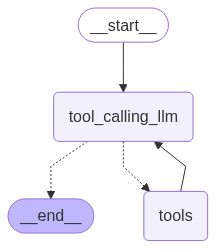

In [37]:
from IPython.display import Image, display
from langgraph.graph import StateGraph,END,START
from langgraph.prebuilt import tools_condition, ToolNode

def tool_calling_llm(state:State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm', tools_condition)
builder.add_edge('tools','tool_calling_llm')

graphs = builder.compile()
display(Image(graphs.get_graph().draw_mermaid_png()))

In [38]:
messages=graphs.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for june 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for june 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (brbr9pp51)
 Call ID: brbr9pp51
  Args:
    query: top 10 recent AI news june 3rd 2025
  add (erbf2ptj8)
 Call ID: erbf2ptj8
  Args:
    a: 5
    b: 5
  multiply (8mjcgqtm6)
 Call ID: 8mjcgqtm6
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News Highlights from 3rd of June, 2025 - LinkedIn", "url": "https://www.linkedin.com/pulse/ai-news-highlights-from-3rd-june-2025-grok-ai-7nnpe", "content": "Character.AI has expanded beyond chatbots with two new tools: Scenes for storytelling and AvatarFX for converting images into animated avatars.", "score": 0.8872928}, {"title": "Global AI Regulat

In [ ]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")




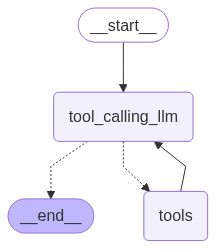

In [40]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory  = builder.compile(checkpointer=memory)
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [41]:
config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (25k0n0z4j)
 Call ID: 25k0n0z4j
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of adding 12 and 13 is 25.


In [42]:
messages = [HumanMessage(content="Take the previous result and add 25 to it")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (25k0n0z4j)
 Call ID: 25k0n0z4j
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of adding 12 and 13 is 25.
================================ Human Message =================================

Take the previous result and add 25 to it
================================== Ai Message ==================================
Tool Calls:
  add (ptzh5syf3)
 Call ID: ptzh5syf3
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The result of adding 25 to the previous result (25) is 50.


In [43]:
messages = [HumanMessage(content="then multiplty previous number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (25k0n0z4j)
 Call ID: 25k0n0z4j
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of adding 12 and 13 is 25.
================================ Human Message =================================

Take the previous result and add 25 to it
================================== Ai Message ==================================
Tool Calls:
  add (ptzh5syf3)
 Call ID: ptzh5syf3
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The result of adding 25 to the previous result (25) is 50.
==========

In [44]:
messages = [HumanMessage(content="then divide previous number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (25k0n0z4j)
 Call ID: 25k0n0z4j
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The result of adding 12 and 13 is 25.
================================ Human Message =================================

Take the previous result and add 25 to it
================================== Ai Message ==================================
Tool Calls:
  add (ptzh5syf3)
 Call ID: ptzh5syf3
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ==================================

The result of adding 25 to the previous result (25) is 50.
==========